In [1]:
%matplotlib inline
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import cv2

# Importing the datasets 

In [2]:
training_file = "train.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

## Dataset facts 

In [3]:
n_train = len(y_train)
n_test = len(y_test)
image_shape  = np.shape(X_train[1])
n_classes = len(np.unique(y_train))

img_size_flat = image_shape[0] * image_shape[1]

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

print("Image Size Flat =", img_size_flat)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43
Image Size Flat = 1024


# One-hot encoding the labels

In [4]:
y_train_encoded = np.eye(43)[y_train]
y_test_encoded = np.eye(43)[y_test]

In [5]:
image_shape[0]

32

In [6]:
np.min(X_train)

0

# Pre-processing the images


In [7]:
def pre_process_image(image):
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (32,32),interpolation = cv2.INTER_CUBIC)
    
    #Min-Max scaling for greyscale image data
    Xmin = 0
    Xmax = 255
    a = 0.1
    b = 0.9
    
    image = a + ((image - Xmin) * (b-a)) / (Xmax-Xmin)
    return image

In [8]:
image_GS_train = np.array([pre_process_image(X_train[i]) for i in range(len(X_train))], dtype = np.float32)
image_GS_test = np.array([pre_process_image(X_test[i]) for i in range(len(X_test))], dtype = np.float32)

In [9]:
image_flat_train = image_GS_train.reshape((-1,img_size_flat))
image_flat_test  = image_GS_test.reshape((-1,img_size_flat))

In [38]:
def process_and_flatten(image_array):
    images_gray = np.array([pre_process_image(image_array[i]) for i in range(len(image_array))], dtype = np.float32)
    images_flat= images_gray.reshape((-1,img_size_flat))
#         Min-Max scaling for greyscale image data
    Xmin = 0
    Xmax = 255
    a = 0.1
    b = 0.9
    
    images_new = a + ((images_flat - Xmin) * (b-a)) / (Xmax-Xmin)
    return images_new

In [11]:
(image_flat_train[0])

array([ 0.34470588,  0.33843136,  0.36352941, ...,  0.41058823,
        0.40431371,  0.39490196], dtype=float32)

# Batching

In [12]:
def random_batch():
    # Number of images in the training-set.
    num_images = len(image_flat_train)

    # Create a random index.
    idx = np.random.choice(num_images,
                           size=batch_size,
                           replace=False)

    # Use the random index to select random images and labels.
    features_batch = image_flat_train[idx, :]
    labels_batch = y_train_encoded[idx, :]

    return features_batch, labels_batch

# Setting up the TensorFlow model

## setting up the constants

In [13]:
x = tf.placeholder(tf.float32, [None, img_size_flat])
y = tf.placeholder(tf.float32, [None, n_classes])

# sets up a place for the non one-hot classes to go
y_true_cls = tf.placeholder(tf.int64, [None])

## network parameters


In [14]:
n_hidden_1 = 1024
n_hidden_2 = 256

## setting up the variables (the things that change -- weights and biases)

In [15]:
# weights = tf.Variable(tf.zeros([img_size_flat, n_classes]))
# biases = tf.Variable(tf.zeros([n_classes]))

# weights = {
#     'h1': tf.Variable(tf.zeros([img_size_flat,n_hidden_1])),
#     'h2': tf.Variable(tf.zeros([n_hidden_1, n_hidden_2])),
#     'out': tf.Variable(tf.zeros([n_hidden_2,n_classes])) 
# }

# biases = {
#     'b1': tf.Variable(tf.zeros([n_hidden_1])),
#     'b2': tf.Variable(tf.zeros([n_hidden_2])),
#     'out': tf.Variable(tf.zeros([n_classes]))
# }
weights = [
        tf.Variable(tf.random_normal([img_size_flat,n_hidden_1])),
        tf.Variable(tf.random_normal([n_hidden_1,n_classes]))]
                    
biases = [
    tf.Variable(tf.random_normal([n_hidden_1])),
    tf.Variable(tf.random_normal([n_classes]))]

## model hyperparameters

In [16]:
learning_rate = 0.1
# n_iterations = 10001
batch_size = 200
display_step = 100


# TensorFlow model

In [17]:
# logits = tf.matmul(x, weights) + biases
# y_pred = tf.nn.softmax(logits)
# y_pred_cls = tf.argmax(y_pred, dimension = 1)

# cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels= y)
# cost = tf.reduce_mean(cross_entropy)

# # optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(cost)
# optimizer = tf.train.AdagradOptimizer(learning_rate = 1e-2).minimize(cost)

# correct_prediction = tf.equal(y_pred_cls, y_true_cls)
# accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))





In [18]:
# logits_1 = tf.matmul(x, weights['h1']) + biases['b1']
# logits_1 = tf.nn.relu(logits_1)

# logits_2 = tf.matmul(logits_1, weights['h2']) + biases['b2']
# logits_2 = tf.nn.relu(logits_2)

# output_layer = tf.matmul(logits_2, weights['out']) + biases['out']


# y_pred = tf.nn.softmax(output_layer)
# y_pred_cls = tf.argmax(y_pred, dimension = 1)


hidden_layer = tf.matmul(x, weights[0]) + biases[0]
# apply activation with single Relu
hidden_layer = tf.nn.relu(hidden_layer)
logits = tf.matmul(hidden_layer, weights[1]) + biases[1]

y_pred = tf.nn.softmax(logits)
y_pred_cls = tf.argmax(y_pred, dimension = 1)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, y))

optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(cost)


correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


# TensorFlow Session


In [19]:
def optimize(n_iterations):
      for iteration in range(n_iterations):
        features_batch, labels_true_batch = random_batch()
        feed_dict_batch = {x: features_batch, y: labels_true_batch}
        sess.run(optimizer, feed_dict = feed_dict_batch)
        

In [20]:
sess = tf.Session()


In [21]:
start_time = time.time()
sess.run(tf.initialize_all_variables())

optimize(50000)

end_time = time.time()
compute_time = end_time - start_time

print("compute time: " , str(timedelta(seconds = int(round(compute_time)))))

compute time:  0:15:05


## Getting the accuracy on the Test Set

In [22]:
feed_dict_test = {x: image_flat_test,
                  y: y_test_encoded,
                  y_true_cls:y_test}

In [23]:

acc = sess.run(accuracy,feed_dict=feed_dict_test)
print(acc)
    

0.74133



# Predicting the class for one image

helpful source: http://stackoverflow.com/questions/33711556/making-predictions-with-a-tensorflow-model

In [24]:
image_flat_train[0]

array([ 0.34470588,  0.33843136,  0.36352941, ...,  0.41058823,
        0.40431371,  0.39490196], dtype=float32)

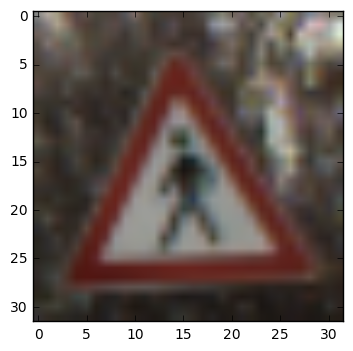

In [25]:
plt.imshow(X_test[10000])

In [26]:
y_test[10000]

27

In [35]:
feed_dict = {x: image_flat_test[9998:10007]}
classification = sess.run(y_pred, feed_dict)
cls = np.argmax(classification, axis=1)
print(cls)

[25  2 27 18 20 38 25 13  8]


In [36]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    #create figure with 3x3 sub-plots
    fig, axes = plt.subplots(3,3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        #plot image
        ax.imshow(images[i].reshape(32,32),  cmap='Greys_r')
        
        # show true and predicted classes
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])
        
        ax.set_xlabel(xlabel)
        
        # remove ticks from the plot 
        ax.set_xticks([])
        ax.set_yticks([])

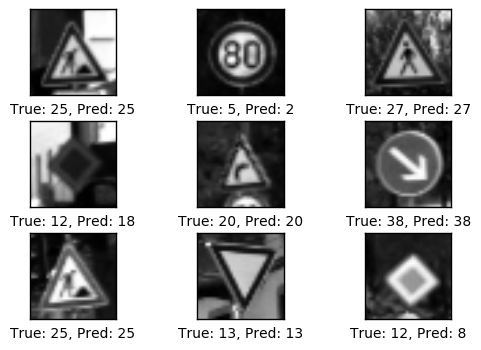

In [37]:
images =image_flat_test[9998:10007]
cls_true = y_test[9998:10007]
plot_images(images = images, cls_true = cls_true, cls_pred = cls)

In [28]:
import os, glob

new_signs= list()

path = "/home/deep_cat/traffic-signs-tensorflow/new_test_images"
test = os.path.join(path, '*.jpg')
print(test)

for infile in glob.glob(os.path.join(path, '*.jpg')):
    print(infile)
    img = cv2.imread(infile)
    arr1 = np.array(img)
    resize_img = cv2.resize(arr1, (32,32))
    new_signs.append(resize_img)
print(np.shape(new_signs))

/home/deep_cat/traffic-signs-tensorflow/new_test_images/*.jpg
/home/deep_cat/traffic-signs-tensorflow/new_test_images/459381023.jpg
/home/deep_cat/traffic-signs-tensorflow/new_test_images/459381275.jpg
/home/deep_cat/traffic-signs-tensorflow/new_test_images/465921877.jpg
/home/deep_cat/traffic-signs-tensorflow/new_test_images/459381095.jpg
/home/deep_cat/traffic-signs-tensorflow/new_test_images/469763307.jpg
/home/deep_cat/traffic-signs-tensorflow/new_test_images/459381273.jpg
(6, 32, 32, 3)


In [29]:
new_signs = np.array(new_signs)

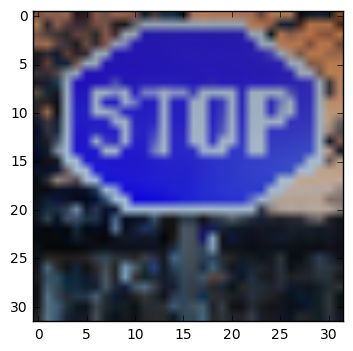

In [30]:
plt.imshow(new_signs[5])

In [39]:
new_signs_flat = process_and_flatten(new_signs)

In [40]:
new_signs_flat

array([[ 0.10142592,  0.10143576,  0.10143576, ...,  0.10054994,
         0.10139639,  0.10054994],
       [ 0.10134718,  0.10138655,  0.10140623, ...,  0.10179993,
         0.10165229,  0.10189835],
       [ 0.10106175,  0.10094364,  0.10076647, ...,  0.10115033,
         0.10098301,  0.10119954],
       [ 0.10056963,  0.10044168,  0.10053026, ...,  0.10066805,
         0.10066805,  0.1005401 ],
       [ 0.10152434,  0.10172118,  0.10145544, ...,  0.10057947,
         0.10053026,  0.10063852],
       [ 0.10108143,  0.10127828,  0.10122906, ...,  0.10061884,
         0.10083538,  0.10058931]], dtype=float32)

In [45]:
feed_dict = {x: new_signs_flat}
classification = sess.run(y_pred, feed_dict)

cls = np.argmax(classification, axis=1)
print(cls)


[8 8 8 8 8 8]


In [46]:
print(classification[0])

[  8.77370883e-04   1.43606616e-02   1.40742315e-02   6.81474507e-02
   2.45272648e-02   1.01672329e-01   1.30246347e-03   9.79561508e-02
   2.48336896e-01   2.43996922e-02   5.12323454e-02   1.39484294e-02
   9.27979499e-02   9.10631940e-03   5.64186601e-03   1.02539724e-02
   3.30792787e-03   3.71244922e-03   8.47817585e-03   4.75233328e-03
   1.97745040e-02   1.42229209e-03   9.83313657e-06   7.04448344e-03
   4.70281625e-03   2.05613635e-02   6.94598304e-03   1.90611067e-03
   5.51432557e-03   5.80165116e-03   6.99817855e-03   2.52561215e-02
   3.30917747e-03   7.66789354e-03   1.30108977e-03   9.89393704e-03
   2.84324284e-03   1.19537348e-03   3.64996865e-02   8.96892743e-05
   3.04974951e-02   5.44657931e-04   1.33380329e-03]
